# Cambridge Analytica & Facebook Reactions on Twitter



In [1]:
import zipfile
import time
import random
import collections
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('fivethirtyeight')

def read_data(filename, frac=0.65):
    "Extract the first file enclosed in a zip file as a list of documents."
    dtypes = {"created": str, "text": str, "tags": str}
    names = ["created", "text", "tags"]
    with zipfile.ZipFile(filename) as z:
        df = pd.read_csv(z.open(z.namelist()[0]), 
                         delimiter='\t', 
                         names=names,
                         dtype=dtypes,
                         na_filter=False)
    df.created = pd.to_datetime(df.created, format="%d/%m/%Y %H:%M:%S")
     
    return df.sample(frac=frac, replace=True)

cat = " ".join

In [2]:
df = read_data("../data/fb_scandal.tsv.zip")
print("Dataset info")
print(df.dtypes)
print("shape", df.shape)

Dataset info
created    datetime64[ns]
text               object
tags               object
dtype: object
shape (337202, 3)


## Spam & Bot Filtering

A quick look through the hashtags of tweets revealed that the topic followed has been significantly target by spam users. This was most concretely revealed by looking at the co-occurances of sets of hashtags. An example of this could be say for instance finding `1000` tweets with exactly the hashtags:

    #foo #tweet4tweet #bar #MontyPython #fooBar #flyingCircus #CambridgeAnalytica
    
A few cases of this type of collection were present in the data often relating to commerce or other languages this only trending terms in english. One case exhibitied over `2000` tweets with the same 6 hashtags with less than 100 unique words between all of them. This was so significant that it completely disrupted term frequency and term relationship analysis. 

### Filtering Model

This time I have just used some conditional statements on the hashtag frequencies and guessed some cut-off parameters to decide what is spam or not. In pseudo code this can be represented as:
                
            
    IsSpam?(tags) := (TRUE IF tweet_tag_count > ceil ELSE
                      TRUE IF tagset_size > floor AND
                           IF tagset_collection_frequency > lim ELSE
                      FALSE)

With `ceil=10`, `floor=4`, `lim=40` the algorithm ended up filtering `7%` perecent of tweets. Which according this paper (https://arxiv.org/pdf/1703.03107.pdf) is in the right ball park, between `9% - 15%` , maybe a bit on the aggressive side of filtering though.

    spam_sets=27 | maybe_spam=17080 | spam=36925/555697 | remainin_tweets=518772
    

It actually only detected 27 examples of spam which constituted to around 36925/555697 tweets.  

    
A basic make do implementation of this can be found here [spamfilter.py](https://github.com/winstonjay/digitalcitizens/blob/master/text_tools/spamfilter.py).

### Future model?

The typical way to model this is with logistic regression. Spam/ham classification is probally the most common examples used in education concerning binary classification. The classification function for logistic regression can be described as follows:

$\normalsize h_{\theta}(x) = S(\theta^TX)$

Where $S$ is the sigmoid function, $\theta$ is our parameters and $X$ are our features. $\theta$ and $X$ are both m x n matrices. $\theta^T$ is $\theta$ transposed.

Features here for this specfic example could be (the same as descibed earlier):

* $x_1$ = number of tags in a tweet.
* $x_2$ = number of tags in the tagset
* $x_3$ = tagset frequency within the collecton of tweets.

An obvious benifit to this is we can easily constuct and add as many features from the tweets as we want and just optimize the parameters. However without labeled data to hand I couldnt currently optimise this. 

### Language filtering

Language filtering would have been another benficial thing to have done, my raw data didnt collect this information. In the future it should try to see if this helps. After filtering tweets with non-ascii characters it seems spanish tweets are still prevelent. 

### Other Parameters?

This article [http://www.erinshellman.com/bot-or-not/](http://www.erinshellman.com/bot-or-not/) provided some interesting approaches to classifying bots and spam accounts on twitter. https://arxiv.org/pdf/1703.03107.pdf this paper which was link to previously provides approaches primarily focused on metadata and properties of the user account. 

this is a nicely layed out article with nice graphics:
https://www.nytimes.com/interactive/2018/01/27/technology/social-media-bots.html?smid=tw-nytimes&smtyp=cur

In [3]:
def lexical_diversity(text):
    terms = text.split()
    n = float(len(terms))
    return (len(set(terms)) / n if n > 0 else 0)

def tag_count(tags):
    return len(tags.split())

# add some more features.
df['lexical_diversity'] = df.text.apply(lexical_diversity)
tag_n = df.tags.apply(tag_count)
df['tag_n'] = (tag_n - tag_n.mean()) / tag_n.std()

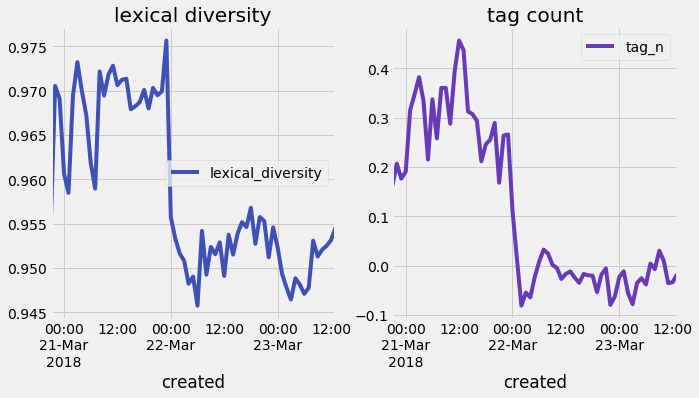

In [4]:
def plot_diversity(df):
    fig, (ax0, ax1) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    ts = df.set_index('created').resample('H').mean()
    ts.plot(ax=ax0, y=["lexical_diversity"], color="#3F51B5", title="lexical diversity")
    ts.plot(ax=ax1, y=["tag_n"], color="#673AB7", title="tag count")
    plt.show()
    
plot_diversity(df)

Thses might be miss-leading graphs, the scales are different but aim mainly foucsing on varience within which one. 
With the pre processing steps performed on that data im not sure what conclusion could be drawn anyway. tag lengths have been capped to below 10. It could suggest a sudden drop of bots tweeting long random sets of tags or words.

## Analysis

In [8]:
def count_terms(terms, stopwords=set()):
    tc = collections.Counter()
    for t in terms:
        tc.update(t.lower().split())
    for s in stopwords:
        del tc[s]
    return tc
    
def plot_counter(counter, n=15, title=None):
    labels, values = list(zip(*counter.most_common(n)[::-1]))
    fig, ax = plt.subplots()
    ind = np.arange(len(labels))
    width = 0.6
    a = ax.barh(ind, values, width)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.legend(a, ("counts",))
    if title is not None:
        ax.set_title(title, y=1.05)
    plt.show()

stopwords = set('''
null cambridgeanalytica cambridgeanalytics facebook 
para todos esta este esto sobre como
'''.split())

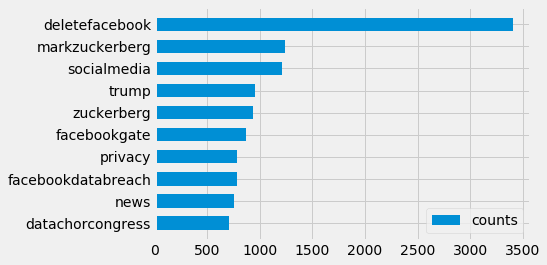

In [6]:
plot_counter(count_terms(df.tags, stopwords), 10)

## word degrees.

we can see the amount of associations a word has by mapping its connections to other words in a graph. 







In [15]:
def word_degree(texts):
    C = collections.Counter()
    tt = 0
    for text in texts:
        terms = set(text.split())
        n = len(terms)
        tt += n
        for t in terms:
            t = t.replace("#", "").replace("@", "")
            if t in stops:
                continue
            C[t] += n
            
            
    print(tt/len(texts))
    return C

stops = set("facebook cambridge_analytica cambridgeanalytica mark_zuckerberg para retweeted".split())

15.224011126861644


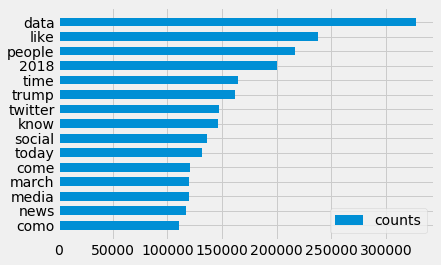

In [16]:
plot_counter(word_degree(df.text))

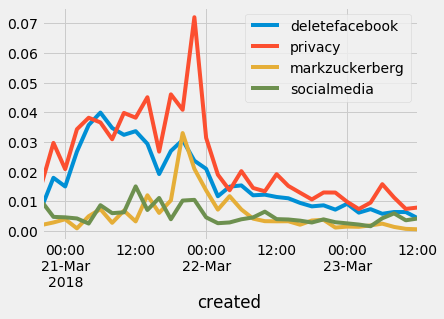

In [7]:
def plot_term_series(*terms, **kwargs):
    fig, ax = plt.subplots()
    for term in terms:
        df[term] = df.text.str.count(term)
    ts = df.set_index('created').resample('2H').mean()
    ts.plot(ax=ax, y=list(terms), **kwargs)
    plt.show()

plot_term_series("deletefacebook", "privacy", "markzuckerberg", "socialmedia")

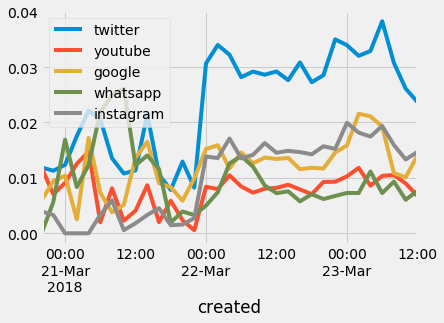

In [8]:
plot_term_series("twitter", "youtube", "google", "whatsapp", "instagram")

## Term Co-occurrence

After using to a tensorflow to perform word vectorisation on the dataset just fillowing this tutorial and using their smaple code: https://www.tensorflow.org/tutorials/word2vec, I have been interested in different ways of accertaining relationships betweet terms. Reading this https://github.com/oxford-cs-deepnlp-2017/lectures/blob/master/Lecture%202a-%20Word%20Level%20Semantics.pdf, I though i could incorperate a variation of the first algorithm described and continue the idea presented:

> "you shall know a word by the company it keeps" (JR Firth, 1957)

As tweets are relitively short it is possible to just set the scan size to all other terms in the document. 

In [3]:
def term_company(tweet_feature, r=2, batch_size=1000):
    C = collections.Counter()
    i = 1 # this goes crazy if not set to 1.
    for tweet in tweet_feature:
        p = itertools.combinations(sorted(set(tweet.split())), r)
        C.update(map(cat, p))
        # to save space just continue with the 50 most common
        # each batch of 1000 tweets.
        if i % batch_size == 0:
            C = collections.Counter(C.most_common(50))
    return C

Performing this on the data we get roughly what you would expect. The data is about facebook data and cambrige analytica data lol.

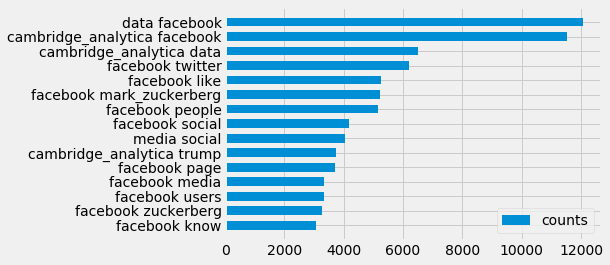

In [10]:
plot_counter(term_company(df.text))

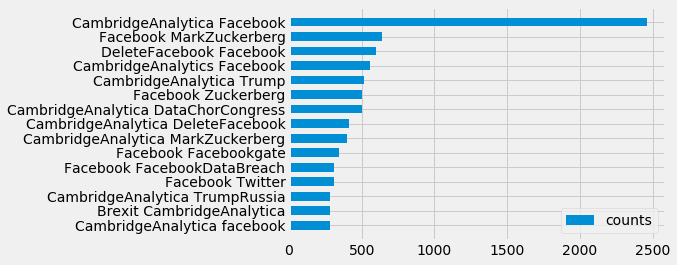

In [11]:
plot_counter(term_company(df.tags))

In [12]:
basis_words = count_terms(df.text, stopwords).most_common(20)

print(basis_words)

[('cambridge_analytica', 28536), ('data', 23684), ('like', 15689), ('people', 14617), ('2018', 14084), ('#cambridgeanalytica', 12590), ('retweeted', 11875), ('#facebook', 11001), ('time', 10540), ('know', 10003), ('trump', 9536), ('today', 8588), ('social', 8373), ('twitter', 7701), ('march', 7588), ('media', 7477), ('come', 7410), ('news', 7325), ('live', 7310), ('mark_zuckerberg', 7210)]


In [4]:
# stops = set("facebook cambridgeanalytica cambridge_analytica".split())

# this is slow and bad but i dont care

df.text = df.text.str.replace("@", "")
df.text = df.text.str.replace("#", "")
df.text = df.text.str.replace("cambridgeanalytica", "cambridge_analytica")
df.text = df.text.str.replace(" zuckerberg", " mark_zuckerberg")
df.text = df.text.str.replace("citizens", "citizen")

def term_company2(tweet_feature, term, r=2, stopwords=stops):
    C = collections.Counter()
    i = 0
    for tweet in tweet_feature:
        if term not in tweet:
            continue
        p = itertools.combinations(sorted(set(tweet.split())), r)
        C.update((cat(a) 
                  for a in p if term in a 
                  and not any(t in stopwords for t in a)))
    return C


NameError: name 'stops' is not defined

In [108]:
# term_company2(df.text, "privacy")

In [5]:
def plot_term_companies(terms, n=12, r=2):
    ind = np.arange(n)
    fig, axes = plt.subplots(len(terms)//2, 2)
    axes = [a for b in axes for a in b]
    width = 0.6
    fig.set_size_inches(10, 10)
    for i, term in enumerate(terms):
        tc = term_company2(df.text, term)
        labels, values = list(zip(*tc.most_common(n)[::-1]))
        a = axes[i].barh(ind, values, width, label=term)
        axes[i].set_xlim([0, 2700])
        axes[i].set_yticks(ind)
        labels = [", ".join(l for l in label.split() if l != term) for label in labels]
        axes[i].set_yticklabels(labels)
        axes[i].set_title("'{}'".format(term))
        for tick in axes[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
        for tick in axes[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(12) 
    plt.tight_layout()
    plt.show()


terms = ("data", "privacy", "citizen", "delete", "trust", "users")
plot_term_companies(terms)

NameError: name 'term_company2' is not defined

## Tf-idf Ngrams

(again).

Just generate the tf-idf scores and plot their mean score accross the dataset for comparison with the guardian dataset. Wont bother taking the time to remove the spanish, french and other language tweets 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

extra_stopwords = set(stopwords.words("spanish")) | set(stopwords.words("french"))

def plot_ngrams(text, n0, n1, n_features=1000, filter_fn=None, **kwargs):
    z = max(n1 - n0,2)
    fig, axis = plt.subplots(1, z)
    fig.set_size_inches(10, 5)
    for i in range(z):
        tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, 
                                     max_features=n_features,
                                     ngram_range=(n0 + i, n0 + i + 1),
                                     stop_words="english")
        tfidf_features = tfidf_vect.fit_transform(text)
        vocab = tfidf_vect.get_feature_names()
        values = tfidf_features.toarray().mean(axis=0)
        if filter_fn:
            sample = [(values[i], k) for i, k in enumerate(vocab) if filter_fn(k)]
        else:
            sample = [(values[i], k) for i, k in enumerate(vocab)]
        v, k = zip(*sorted(sample, reverse=True)[:20])
        dd = pd.DataFrame(index=k, data={"key": k, "tfidf": v})
        dd.plot(kind="barh", ax=axis[i], legend=False, **kwargs).invert_yaxis()
    plt.tight_layout()
    plt.show()

In [167]:
texts = []
for text in df.text:
    if any(t in extra_stopwords for t in text.split()):
        continue
    texts.append(text)

In [1]:
plot_ngrams(texts, 1, 2, color="#E91E63")

In [206]:
terms = (
    "data", "privacy", "people", "delete", "trust", "users", "social", "news")

# again lame but cba and quick and dirty from stuff i done before
vocabCounts = collections.Counter()
for term in terms:
    for k, val in term_company2(df.text, term).most_common(Vn):
        for w in k.split():
            vocabCounts[w] += val
    

In [207]:
from sklearn.feature_extraction.text import CountVectorizer
Vn = 15

vocab = list(dict(vocabCounts.most_common(Vn)).keys())

tf_model = CountVectorizer(stop_words="english", vocabulary=terms)

X = tf_model.fit_transform(texts) 

print(X.shape)

(278913, 8)


In [208]:
print(tf_model.vocabulary_)
y = [""] * Vn
for k, i in tf_model.vocabulary_.items():
    y[i] = k
print(y)
vocab_list = y

{'data': 0, 'privacy': 1, 'news': 7, 'users': 5, 'trust': 4, 'delete': 3, 'people': 2, 'social': 6}
['data', 'privacy', 'people', 'delete', 'trust', 'users', 'social', 'news', '', '', '', '', '', '', '']


In [209]:
def norm(X):
    return (X - X.min()) / (X.max() - X.min())

In [210]:
Xc = (X.T * X)
Xc.setdiag(0)
# Xc = norm(Xc.todense())
X0 = norm(np.array(Xc.todense()))
print(X0)

[[ 0.          0.71211096  0.76657645  0.17658999  0.19316644  1.
   0.57780785  0.48240866]
 [ 0.71211096  0.          0.14377537  0.03822733  0.02774019  0.14512855
   0.1217862   0.0808525 ]
 [ 0.76657645  0.14377537  0.          0.10284168  0.09945873  0.11265223
   0.26116373  0.19959405]
 [ 0.17658999  0.03822733  0.10284168  0.          0.01589986  0.05446549
   0.05818674  0.02909337]
 [ 0.19316644  0.02774019  0.09945873  0.01589986  0.          0.07814614
   0.03958051  0.03247632]
 [ 1.          0.14512855  0.11265223  0.05446549  0.07814614  0.
   0.18132612  0.10385656]
 [ 0.57780785  0.1217862   0.26116373  0.05818674  0.03958051  0.18132612
   0.          0.14512855]
 [ 0.48240866  0.0808525   0.19959405  0.02909337  0.03247632  0.10385656
   0.14512855  0.        ]]


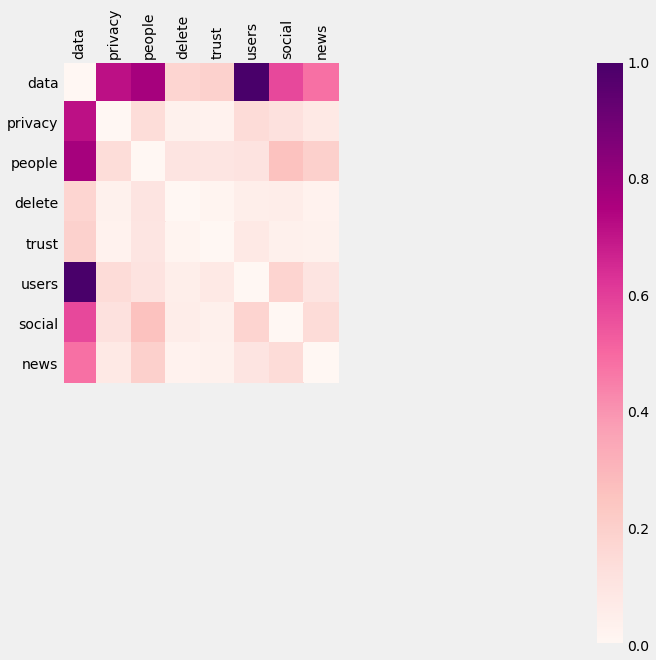

In [211]:
title = "Word Co-occurrances within Tweets"

plt.figure(figsize=(10, 10))
# plt.title(title)
c = plt.pcolor(np.array(X0), cmap='RdPu', vmin=0.0, vmax=1.0)

def show_values(pc, fmt="%.2f", **kwargs):
    pc.update_scalarmappable()
    ax = pc.axes
    ind = np.arange(Vn)
    width = 0.5    
    ax.xaxis.tick_top()
    ax.set_yticks(ind + width)
    plt.xticks(ind + width, vocab_list, rotation='vertical')
    ax.set_yticklabels(vocab_list)
    ax.invert_yaxis()

        
        
show_values(c)


# plt.tight_layout()
plt.colorbar(c)
plt.show()